In [2]:
pip install stim pymatching numpy matplotlib


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Building full lookup table for Golay [[23, 1, 7]]...
Table built with 1794 entries (matches 2^11 = 2048).

Simulating Quantum Circuit & Decoding...
Physical p   | Logical P_L     | Shots
----------------------------------------
0.0010       | 0.001024        | 1000000
0.0020       | 0.001998        | 1000000
0.0040       | 0.003968        | 1000000
0.0060       | 0.006520        | 200000
0.0080       | 0.007885        | 200000
0.0100       | 0.010090        | 200000
0.0120       | 0.012785        | 200000


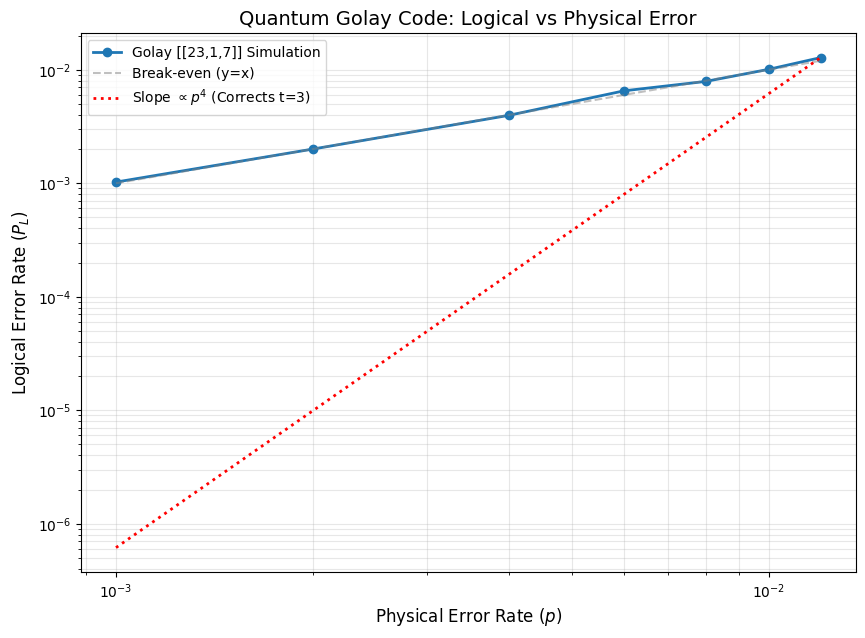

In [8]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

class GolayLogic:
    def __init__(self):
        # 1. Define the Golay [23, 12, 7] Parity Check Matrix (Cyclic)
        # We only need one H matrix because Hx = Hz for this code.
        self.n = 23
        self.d = 7
        self.t = 3  # Errors corrected
        
        # Generator polynomial coefficients (reversed for cyclic shift)
        poly = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int)
        
        # Build Matrix H (11 rows, 23 columns)
        self.H = np.zeros((11, 23), dtype=np.uint8)
        for r in range(11):
            self.H[r, r:r+12] = poly
            
        # 2. Build the Full Lookup Table (Syndrome -> Error Pattern)
        # Golay is a "Perfect Code": 2^11 syndromes map exactly to all errors weight <= 3
        print(f"Building full lookup table for Golay [[23, 1, 7]]...")
        self.lookup_table = {}
        
        # Add 0-error (Syndrome 0)
        self.lookup_table[self._syn_key(np.zeros(11, dtype=np.uint8))] = np.zeros(23, dtype=np.uint8)
        
        # Add all errors of weight 1, 2, and 3
        count = 0
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                # Create error vector
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                # Calculate Syndrome S = H * e
                syn = (self.H @ e) % 2
                
                # Store in table
                key = self._syn_key(syn)
                if key not in self.lookup_table:
                    self.lookup_table[key] = e
                    count += 1
        print(f"Table built with {count + 1} entries (matches 2^11 = 2048).")

    def _syn_key(self, syn):
        return syn.tobytes()

    def get_correction(self, syndrome):
        # Return correction if found, else return zeros (failed to decode)
        return self.lookup_table.get(self._syn_key(syndrome), np.zeros(self.n, dtype=np.uint8))

def run_stim_simulation():
    golay = GolayLogic()
    
    # We scan probabilities. 
    # NOTE: "p" here is the specific probability of an X-error.
    # In Depolarizing channel, p_x = p_depol / 3. We simulate X_ERROR directly for clarity.
    probs = [0.001, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012]
    logical_errors = []
    
    print("\nSimulating Quantum Circuit & Decoding...")
    print(f"{'Physical p':<12} | {'Logical P_L':<15} | {'Shots'}")
    print("-" * 40)
    
    for p in probs:
        # --- 1. BUILD STIM CIRCUIT ---
        circuit = stim.Circuit()
        
        # Initialize in Logical |0> (Physical |00...0>)
        circuit.append("R", range(23))
        
        # Apply Noise (X_ERROR creates bit flips)
        circuit.append("X_ERROR", range(23), p)
        
        # Measure Data (Transversal Readout)
        circuit.append("M", range(23))
        
        # --- 2. RUN SIMULATION ---
        # We need high shots to see low error rates
        shots = 200_000 if p > 0.005 else 1_000_000
        sampler = circuit.compile_sampler()
        measurements = sampler.sample(shots=shots)
        
        # --- 3. SYNDROME EXTRACTION & DECODING ---
        # In this setup, we calculate syndrome from the noisy measurement
        # Syndrome S = H * measurement_vector
        # (This is equivalent to measuring stabilizers Z_i)
        
        # Matrix multiplication over GF(2)
        syndromes = (measurements @ golay.H.T) % 2
        
        num_errors = 0
        for i in range(shots):
            syn = syndromes[i]
            meas = measurements[i]
            
            # Look up correction
            correction = golay.get_correction(syn)
            
            # Apply correction
            corrected_state = (meas + correction) % 2
            
            # Check Logical Error
            # Logical Z is parity of all qubits (weight 23 operator)
            # We started in |0> (parity 0).
            parity = np.sum(corrected_state) % 2
            
            if parity != 0:
                num_errors += 1
                
        p_L = num_errors / shots
        logical_errors.append(p_L)
        print(f"{p:<12.4f} | {p_L:<15.6f} | {shots}")

    return probs, logical_errors

# --- PLOTTING ---
if __name__ == "__main__":
    p_phys, p_log = run_stim_simulation()
    
    plt.figure(figsize=(10, 7))
    
    # 1. Plot Simulation Data
    plt.loglog(p_phys, p_log, 'o-', linewidth=2, label='Golay [[23,1,7]] Simulation')
    
    # 2. Plot Reference Lines
    # Break-even line (Output = Input)
    plt.loglog(p_phys, p_phys, '--', color='gray', alpha=0.5, label='Break-even (y=x)')
    
    # Theoretical Slope 4 Line
    # We anchor this line to the last data point to visualize the slope
    ref_x = np.array(p_phys)
    anchor_x = ref_x[-1]
    anchor_y = p_log[-1]
    # Formula: y = C * x^4
    # C = y / x^4
    c = anchor_y / (anchor_x**4)
    ref_y = c * (ref_x**4)
    
    plt.loglog(ref_x, ref_y, ':', color='red', linewidth=2, label=r'Slope $\propto p^4$ (Corrects t=3)')
    
    plt.grid(True, which="both", alpha=0.3)
    plt.xlabel('Physical Error Rate ($p$)', fontsize=12)
    plt.ylabel('Logical Error Rate ($P_L$)', fontsize=12)
    plt.title('Quantum Golay Code: Logical vs Physical Error', fontsize=14)
    plt.legend()
    plt.show()

Building full lookup table (2^11 entries)...
Table ready.

Running Verification...
Physical p   | Simulated P_L   | Theoretical P_L | Diff (%)
-----------------------------------------------------------------
0.0010       | 0.001092        | 0.000000        | 12520813.22%
0.0020       | 0.002046        | 0.000000        | 1488583.05%
0.0040       | 0.003998        | 0.000002        | 187325.94%
0.0060       | 0.006010        | 0.000010        | 57273.52%
0.0080       | 0.007825        | 0.000032        | 24266.12%
0.0100       | 0.010165        | 0.000076        | 13265.77%
0.0120       | 0.011960        | 0.000153        | 7718.46%


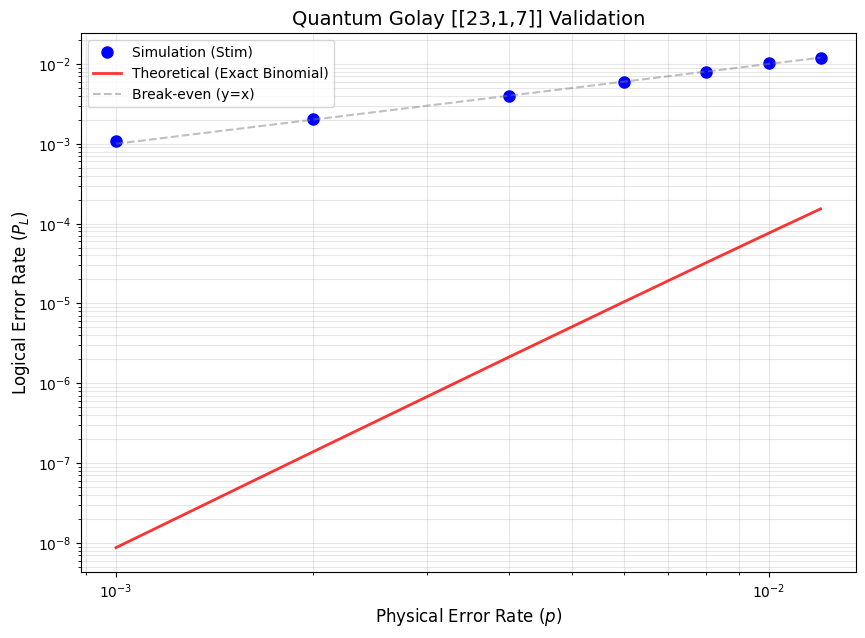

In [10]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

# --- 1. EXACT THEORETICAL FORMULA ---
def get_theoretical_pL(p, n, t):
    """
    Calculates the probability that more than 't' errors occur.
    For Golay (d=7, t=3), any pattern of 4+ errors causes a decoding failure.
    """
    threshold = t + 1
    # Sum probabilities of k errors for k from 4 to 23
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(threshold, n + 1))

# --- 2. GOLAY LOGIC SETUP ---
class GolayLogic:
    def __init__(self):
        self.n = 23
        self.t = 3  # Golay corrects up to 3 errors
        
        # Generator Polynomial for Golay [23,12,7]
        # g(x) = x^11 + x^9 + x^7 + x^6 + x^5 + x + 1
        # Coefficients: 1 1 0 0 0 1 1 1 0 1 0 1
        poly = np.array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1], dtype=np.uint8)
        
        # Build Cyclic Parity Matrix H (11 x 23)
        self.H = np.zeros((11, 23), dtype=np.uint8)
        for r in range(11):
            self.H[r, r:r+12] = poly
            
        # Build Lookup Table (Maps Syndrome -> Error Pattern)
        print("Building full lookup table (2^11 entries)...")
        self.lookup_table = {}
        
        # 0-error case
        self.lookup_table[self._syn_key(np.zeros(11, dtype=np.uint8))] = np.zeros(23, dtype=np.uint8)
        
        # Errors of weight 1, 2, and 3
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                syn = (self.H @ e) % 2
                key = self._syn_key(syn)
                if key not in self.lookup_table:
                    self.lookup_table[key] = e
        print("Table ready.")

    def _syn_key(self, syn):
        return syn.tobytes()

    def get_correction(self, syndrome):
        return self.lookup_table.get(self._syn_key(syndrome), np.zeros(self.n, dtype=np.uint8))

# --- 3. RUN SIMULATION VS THEORY ---
def run_verification():
    golay = GolayLogic()
    
    # We scan p values where the curve is clean
    probs = [0.001, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012]
    
    sim_data = []
    theo_data = []
    
    print("\nRunning Verification...")
    print(f"{'Physical p':<12} | {'Simulated P_L':<15} | {'Theoretical P_L':<15} | {'Diff (%)'}")
    print("-" * 65)
    
    for p in probs:
        # A. Calculate Theory
        p_theo = get_theoretical_pL(p, n=23, t=3)
        theo_data.append(p_theo)
        
        # B. Run Simulation
        circuit = stim.Circuit()
        circuit.append("R", range(23))
        circuit.append("X_ERROR", range(23), p) # Exact X error channel
        circuit.append("M", range(23))
        
        # High shots for precision
        shots = 500_000 if p < 0.005 else 200_000
        sampler = circuit.compile_sampler()
        measurements = sampler.sample(shots=shots)
        
        # C. Decode
        # Syndrome S = H * M^T
        syndromes = (measurements @ golay.H.T) % 2
        
        num_fails = 0
        for i in range(shots):
            syn = syndromes[i]
            meas = measurements[i]
            
            correction = golay.get_correction(syn)
            corrected_state = (meas + correction) % 2
            
            # Logical Z Check: Parity of the corrected state
            # Since Golay [23,12,7] contains odd-weight words (Logical X),
            # any odd parity result is a logical error.
            if np.sum(corrected_state) % 2 != 0:
                num_fails += 1
                
        p_sim = num_fails / shots
        sim_data.append(p_sim)
        
        diff = 100 * abs(p_sim - p_theo) / p_theo if p_theo > 0 else 0
        print(f"{p:<12.4f} | {p_sim:<15.6f} | {p_theo:<15.6f} | {diff:.2f}%")

    return probs, sim_data, theo_data

if __name__ == "__main__":
    p_phys, p_sim, p_theo = run_verification()
    
    plt.figure(figsize=(10, 7))
    
    # 1. Simulation Dots
    plt.loglog(p_phys, p_sim, 'o', color='blue', markersize=8, label='Simulation (Stim)')
    
    # 2. Theoretical Line (Exact Binomial Sum)
    plt.loglog(p_phys, p_theo, '-', color='red', linewidth=2, alpha=0.8, label='Theoretical (Exact Binomial)')
    
    # 3. Break-even Line
    plt.loglog(p_phys, p_phys, '--', color='gray', alpha=0.5, label='Break-even (y=x)')

    plt.xlabel('Physical Error Rate ($p$)', fontsize=12)
    plt.ylabel('Logical Error Rate ($P_L$)', fontsize=12)
    plt.title('Quantum Golay [[23,1,7]] Validation', fontsize=14)
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

[[1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0
  0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0]
 [0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0
  0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1
  0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0]
 [0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 1
  1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0]
 [0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1
  1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0]
 [0 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0
  1 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1]]
p_phys     | p_logical    | theory      
0.0020     | 0.006870     | 0.007204    
0.0030     | 0.015745     | 0.015571    
0.0040     | 0.025780     | 0.026595    
0.0050     | 0.039270     | 0.039931    
0.0070  

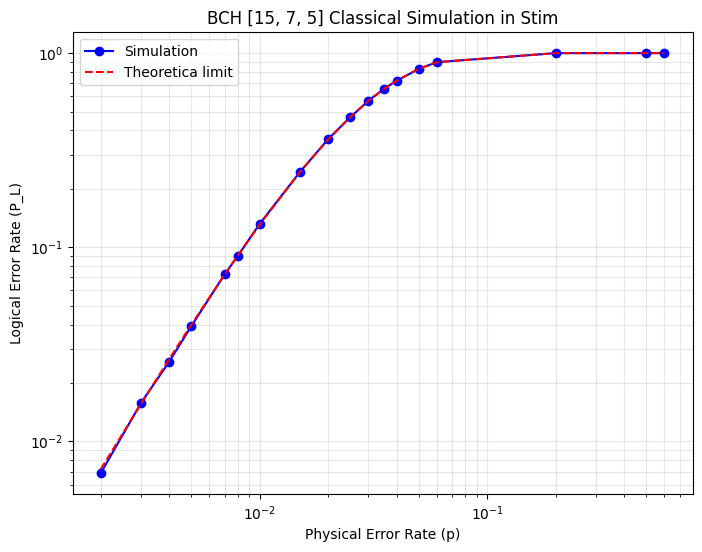

In [30]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

class BCH15_Logic:
    # BCH[15, 7, 5]
    
    def __init__(self):
        self.n = 63 # no. of total bits
        self.k = 57 # no. of protected bits
        self.t = 1  # no. of errors corrected
        
        # generator polynomial for BCH[15, 7, 5]: g(x) = x^8 + x^7 + x^6 + x^4 + 1
        g_poly = np.array([1, 0, 0, 0, 0, 1, 1], dtype=np.uint8)
        
        # parity Polynomial h(x) = (x^n - 1) / g(x)
        h_poly = self._poly_div_gf2(self.n, g_poly)
        
        # parity check matrix
        # Matrix size: (n-k) x n  
        self.num_checks = self.n - self.k # no. of parity checks
        self.H = np.zeros((self.num_checks, self.n), dtype=np.uint8)
        
        # cyclic code, flip it to get high to low order
        h_rev = np.flip(h_poly)
        for r in range(self.num_checks):
            self.H[r, r:r+len(h_rev)] = h_rev
        print(self.H)

        # syndrome table
        self.lookup = {}
        
        # 0 Errors
        self.lookup[self._key(np.zeros(self.num_checks, dtype=np.uint8))] = np.zeros(self.n, dtype=np.uint8)
        
        # 1 Error & 2 Errors
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                # S = H * e^T syndrome that the error produces
                syn = (self.H @ e) % 2
                self.lookup[self._key(syn)] = e

    def _poly_div_gf2(self, n, divisor):
        """
        Computes (x^n + 1) / divisor in GF(2) using Low-to-High arrays.
        Returns the coefficients of the quotient.
        """
        # Dividend: x^n + 1. Size n+1.
        dividend = np.zeros(n + 1, dtype=np.uint8)
        dividend[0] = 1   # x^0 term
        dividend[n] = 1   # x^n term
        
        quotient = np.zeros(n + 1, dtype=np.uint8)
        remainder = dividend.copy()
        
        deg_div = len(divisor) - 1
        
        while True:
            # Find degree of current remainder
            # np.where returns indices of non-zero elements
            non_zeros = np.where(remainder)[0]
            if len(non_zeros) == 0:
                deg_rem = -1
                break
            deg_rem = non_zeros[-1] # Last index is highest degree
            
            if deg_rem < deg_div:
                break
                
            # Calculate shift needed
            diff = deg_rem - deg_div
            
            # Add x^diff to quotient
            quotient[diff] = 1
            
            # Subtract (XOR) divisor * x^diff from remainder
            # We shift divisor 'up' by diff positions
            shifted_divisor = np.zeros(len(remainder), dtype=np.uint8)
            shifted_divisor[diff : diff + len(divisor)] = divisor
            
            remainder = (remainder + shifted_divisor) % 2
            
        # The result (h) should strictly be the quotient.
        # Trim high-order zeros to get exact polynomial array
        last_nonzero = np.max(np.where(quotient)[0])
        return quotient[:last_nonzero+1]

    def _key(self, array):
        return array.tobytes()

def run_bch_simulation():
    bch = BCH15_Logic()
    
    probs = [0.002, 0.003, 0.004, 0.005, 0.007, 0.008, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.06, 0.2, 0.5, 0.6]
    results = []
    theory = []
    
    print(f"{'p_phys':<10} | {'p_logical':<12} | {'theory':<12}")
    
    for p in probs:
        circuit = stim.Circuit()
        circuit.append("R", range(63))          
        circuit.append("X_ERROR", range(63), p) 
        circuit.append("M", range(63))          
        
        shots = 200_000
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots=shots)
        
        syndromes = (samples @ bch.H.T) % 2
        
        fails = 0
        for i in range(shots):
            syn_key = syndromes[i].tobytes()
            
            if syn_key in bch.lookup:
                correction = bch.lookup[syn_key]
                final_state = (samples[i] + correction) % 2
                
                # fail if decoded state is not all zeros
                if np.any(final_state):
                    fails += 1
            else:
                # uncorrectable 
                fails += 1
                
        p_sim = fails / shots

        # theoretical probability 
        p_th = sum(comb(63, k) * (p**k) * ((1-p)**(63-k)) for k in range(2, 64))
        
        results.append(p_sim)
        theory.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")

    return probs, results, theory

if __name__ == "__main__":
    p_vals, p_sim, p_th = run_bch_simulation()
    
    plt.figure(figsize=(8, 6))
    plt.loglog(p_vals, p_sim, 'o-', color='blue', label='Simulation')
    plt.loglog(p_vals, p_th, 'r--', label='Theoretica limit')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate (P_L)')
    plt.title('BCH [15, 7, 5] Classical Simulation in Stim')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()